# Capstone Project 1: Statistical Data Analysis

Data source: https://www.yelp.com/dataset.

To recap, this project explores yelp restaurants data for insights that might be helpful to future restaurateurs. In this exploration of the yelp restaurants dataset, we will perform the statistical analysis for aspects of the data that piqued our interest during the visualizations in data storytelling:
1. Some restaurant categories have significantly more restaurants in good standing with 4-5 stars than in moderate and poor standing. Does restaurant category affect restaurant standing?

2. Moderate restaurants with 2.5 to 3.5 stars experience more volatile ratings over time than good and poor restaurants. Do mediocre restaurants experience higher volatility and lower consistency?

3. Price range does not affect ratings. Can restaurant standing only be improved with investing in attributes that require more complex management, like having reservations, outdoor seating and alcohol?

4. The chance of a Chinese restaurant being good in New York increases as it moves farther away from other Chinese restaurants. Does restaurant density affect restaurant standing for restaurants of specific types? 

In [1]:
# Read the stored dataframes from Capstone Project 1: Data Wrangling in file data_wrangling
%store -r goodr
%store -r modr
%store -r poorr
%store -r goodr_checkins
%store -r modr_checkins
%store -r poorr_checkins
%store -r rests
%store -r goodrv
%store -r modrv
%store -r poorrv

In [2]:
# Import the necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from numpy.random import seed
from scipy.stats import t
from scipy.stats import norm
from scipy import stats
from math import sin, cos, sqrt, atan2, radians

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")

## I. Distribution of Ratings

The Yelp dataset presents a sample of 39630 restaurants from 543 cities across the world. These restaurants have an average rating of 3.5 stars with a standard deviation of 0.71. 

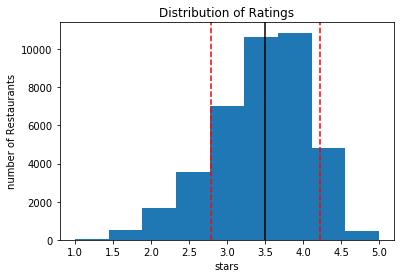

In [3]:
# Get the ratings of all restaurants and plot them in a histogram
ratings = rests['stars']
ratings_mean = np.mean(ratings)
ratings_std = np.std(ratings,ddof=1)
_ = plt.hist(ratings,bins=9)
_ = plt.xlabel('stars')
_ = plt.ylabel('number of Restaurants')
_ = plt.title('Distribution of Ratings')
_ = plt.axvline(ratings_mean, color='k',linestyle='-')
_ = plt.axvline(ratings_mean+ratings_std,color='r',linestyle='--')
_ = plt.axvline(ratings_mean-ratings_std,color='r',linestyle='--')

In [4]:
ratings_mean

3.5049078980570276

In [5]:
ratings_std

0.7124094329294598

In [6]:
# Write function to get bootstrap replicate data
def bootstrap_replicate(data,func):
    bs_sample = np.random.choice(data,size=len(data))
    return func(bs_sample)

In [7]:
# Create draw bootstrap replicates function
def draw_bs_replicates(data,func,size):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate(data,func)
    return bs_replicates

## II. Restaurant Category and Restaurant Standing
Bootstrap inference will be used to perform t-tests on the following hypothesis.

#### Null hypothesis:
There is no difference in ratings between restaurants regardless of restaurant category.

#### Alternative hypothesis:
There is significant difference in ratings between restaurants depending on restaurant category.

In [8]:
# Create user defined function that returns list of ratings for certain categories
def category_filter(df,cats):
    return [df[df['categories'].str.contains(c)]['stars'] for c in cats]

In [9]:
# Create list of categories we want to test
categories = ['Vegetarian','Vegan','Dessert','Food Truck','Tacos','Juice','Coffee']

In [10]:
# Create function that shifts the ratings for each category
def category_shift(data):
    return data - np.mean(data) + ratings_mean

In [11]:
# Get the shifted ratings for restaurants by category
shifted_ratings = [category_shift(r) for r in category_filter(rests,categories)]

In [12]:
# Get bootstrap replicates of shifted ratings
bs_reps_cat = [draw_bs_replicates(s,np.mean,10000) for s in shifted_ratings]

# Get the differences in the mean ratings
bs_reps = [x-ratings_mean for x in bs_reps_cat]

In [13]:
# Calculate test statistics which is the observed difference in the means
tt = [np.mean(x)-ratings_mean for x in category_filter(rests,categories)]

In [14]:
# Calculate the p values
pvals = [np.sum(x>=t)/len(x) for x,t in zip(bs_reps,tt)]

In [15]:
pvals

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0055]

With p values of 0, the null hypothesis is rejected for each of the categories investigated. There exists significant difference in the ratings between restaurants depending on category.

In [16]:
# Calculate the 95% confidence intervals by using the percentiles
ci = [np.percentile(x,[2.5,97.5]) for x in bs_reps]
ci

[array([-0.03315217,  0.03315217]),
 array([-0.03722628,  0.03722628]),
 array([-0.03267254,  0.03340675]),
 array([-0.0619195 ,  0.05727554]),
 array([-0.08490566,  0.08018868]),
 array([-0.0520362,  0.0505279]),
 array([-0.03810296,  0.03607621])]

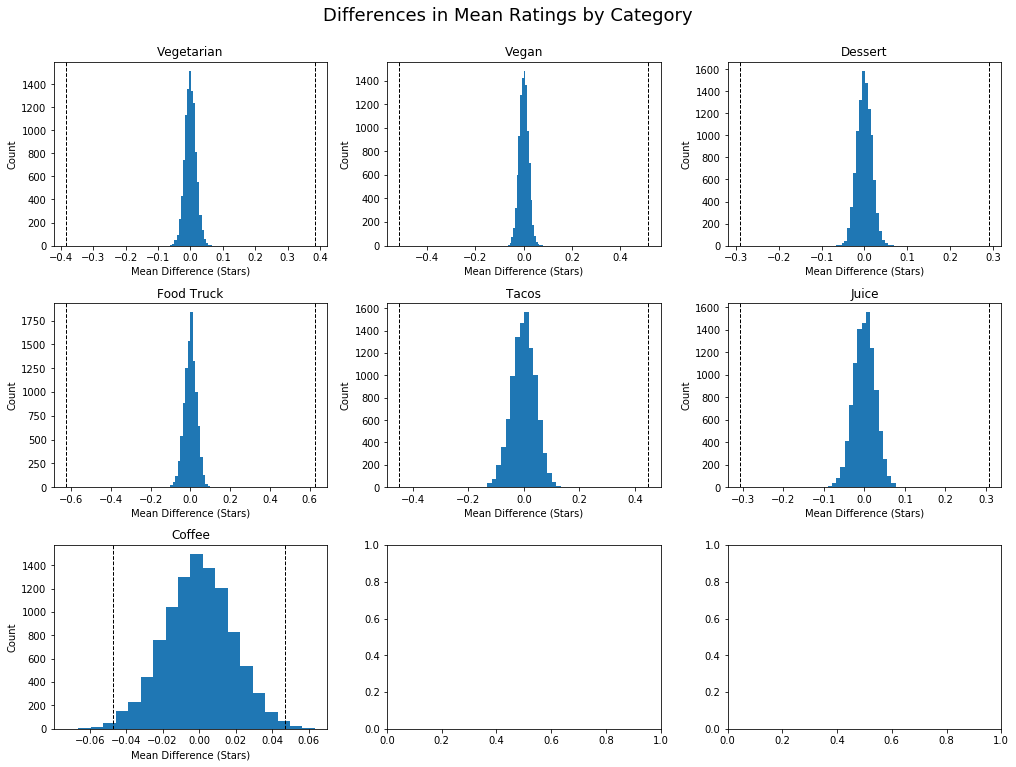

In [17]:
# Plot the differences in mean ratings and the test statistics
fig1,axes1 = plt.subplots(3,3,figsize=(14,10),constrained_layout=True)
fig1.suptitle('Differences in Mean Ratings by Category',size=18,y=1.05)
r = 0
c = 0
for i in range(0,len(categories)):
    axes1[r,c].hist(bs_reps[i],bins=20)
    axes1[r,c].set_title(categories[i])
    axes1[r,c].set(xlabel='Mean Difference (Stars)',ylabel='Count')
    axes1[r,c].axvline(tt[i],color='k',linestyle='dashed',linewidth=1)
    axes1[r,c].axvline(-tt[i],color='k',linestyle='dashed',linewidth=1)
    if c == 2:
        c = 0
        r += 1
    else:
        c += 1
pass;

## III. Restaurant Standing and Rating Volatility

Bootstrap inference will be used to perform t-tests on the following hypothesis.

#### Null hypothesis:
There is no difference in ratings standard deviations between restaurants regardless of restaurant standing.

#### Alternative hypothesis:
There is significant difference in ratings standard deviations between restaurants depending on restaurant standing.

In [18]:
# Get the ratings by standing category
gratings = goodr['stars']
mratings = modr['stars']
pratings = poorr['stars']

In [19]:
# Get the bootstrap replicates of the ratings standard deviations for each standing category
bs_reps_good = draw_bs_replicates(gratings,np.std,10000)
bs_reps_mod = draw_bs_replicates(mratings,np.std,10000)
bs_reps_poor = draw_bs_replicates(pratings,np.std,10000)

# Create empty arrays to store differences
mod_good_diffs = bs_reps_mod - bs_reps_good
poor_good_diffs = bs_reps_poor - bs_reps_good
mod_poor_diffs = bs_reps_mod - bs_reps_poor

In [20]:
# Calculate the 95% confidence intervals by using the 2.5 and 97.5 percentiles
ci_mod_good = np.percentile(mod_good_diffs,[2.5,97.5])
ci_poor_good = np.percentile(poor_good_diffs,[2.5,97.5])
ci_mod_poor = np.percentile(mod_poor_diffs,[2.5,97.5])

In [21]:
# Calculate the test statistics and p values
ht_mod_good = stats.ttest_ind(bs_reps_mod,bs_reps_good,equal_var=False)
ht_poor_good = stats.ttest_ind(bs_reps_poor,bs_reps_good,equal_var=False)
ht_mod_poor = stats.ttest_ind(bs_reps_mod,bs_reps_poor,equal_var=False)

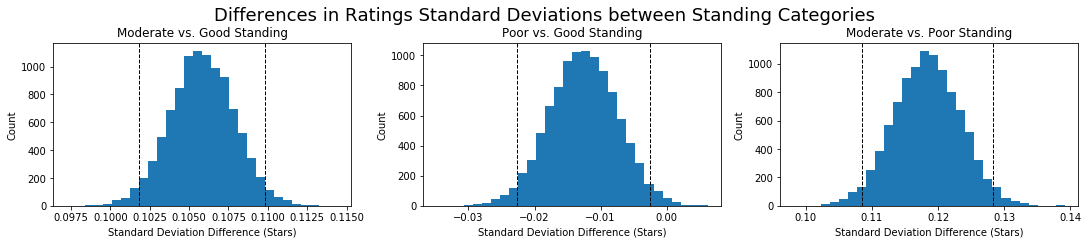

In [22]:
# Plot the histograms of the differences in the replicates and the 95% confidence intervals
diffs = [mod_good_diffs,poor_good_diffs,mod_poor_diffs]
cis = [ci_mod_good,ci_poor_good,ci_mod_poor]
fig2,axes2 = plt.subplots(1,3,figsize=(15,3),constrained_layout=True)
fig2.suptitle('Differences in Ratings Standard Deviations between Standing Categories',size=18,y=1.08)
c = 0
for i in range(3):
    axes2[c].hist(diffs[i],bins=30)
    if i == 0:
        title = 'Moderate vs. Good Standing'
    elif i == 1:
        title = 'Poor vs. Good Standing'
    else:
        title = 'Moderate vs. Poor Standing'
    axes2[c].set_title(title)
    axes2[c].set(xlabel='Standard Deviation Difference (Stars)',ylabel='Count')
    axes2[c].axvline(cis[i][0],color='k',linestyle='dashed',linewidth=1)
    axes2[c].axvline(cis[i][1],color='k',linestyle='dashed',linewidth=1)
    c += 1
pass;

In [23]:
# Show the p-values of the differences
ht_mod_good, ht_poor_good, ht_mod_poor

(Ttest_indResult(statistic=5184.292433505719, pvalue=0.0),
 Ttest_indResult(statistic=-244.50990382811972, pvalue=0.0),
 Ttest_indResult(statistic=2342.3213385486088, pvalue=0.0))

With p values of 0, I reject the null hypothesis. There exists significant difference in ratings standard deviation between restaurants depending on restaurant standing. 

## IV. Restaurant Attributes and Restaurant Standing

Bootstrap inference will be used to perform t-tests on the following hypothesis.

#### Null hypothesis:

There is no difference in ratings between restaurants regardless of attributes possessed.

#### Alternative hypothesis:

There is significant difference in ratings between restaurants depending on the attributes possessed.

In [24]:
# Get ratings by attributes
ratings_alcohol = rests[rests['Alcohol']!='none']['stars']
ratings_noalcohol = rests[rests['Alcohol']=='none']['stars']
ratings_reservations = rests[rests['RestaurantsReservations']=='True']['stars']
ratings_noreservations = rests[rests['RestaurantsReservations']=='False']['stars']
ratings_outdoor = rests[rests['OutdoorSeating']=='True']['stars']
ratings_nooutdoor = rests[rests['OutdoorSeating']=='False']['stars']
ratings_atts = [ratings_alcohol,ratings_noalcohol,ratings_reservations,ratings_noreservations,ratings_outdoor,ratings_nooutdoor]

In [25]:
# Get the shifted ratings by attribute/lack of attributes
shifted_atts = [category_shift(x) for x in ratings_atts]

In [26]:
# Get bootstrap replicates of shifted ratings
bs_reps_atts = [draw_bs_replicates(x,np.mean,10000) for x in shifted_atts]

# Get the differences in the mean ratings
alcohol_noalcohol = bs_reps_atts[0] - bs_reps_atts[1]
res_nores = bs_reps_atts[2] - bs_reps_atts[3]
out_noout = bs_reps_atts[4] - bs_reps_atts[5]

In [27]:
# Calculate the test statistics and p values
tt_alcohol = stats.ttest_ind(bs_reps_atts[0],bs_reps_atts[1])
tt_reservations = stats.ttest_ind(bs_reps_atts[2],bs_reps_atts[3])
tt_outdoor = stats.ttest_ind(bs_reps_atts[4],bs_reps_atts[5])
tt_alcohol,tt_reservations,tt_outdoor

(Ttest_indResult(statistic=-0.37926153279585084, pvalue=0.7044976887563638),
 Ttest_indResult(statistic=-1.9737768168231553, pvalue=0.04842086845127091),
 Ttest_indResult(statistic=-0.0800242663557761, pvalue=0.9362187568436483))

I accept the null hypothesis with p values being greater than 0.05. There is no difference in ratings between restaurants regardless of attributes possessed.

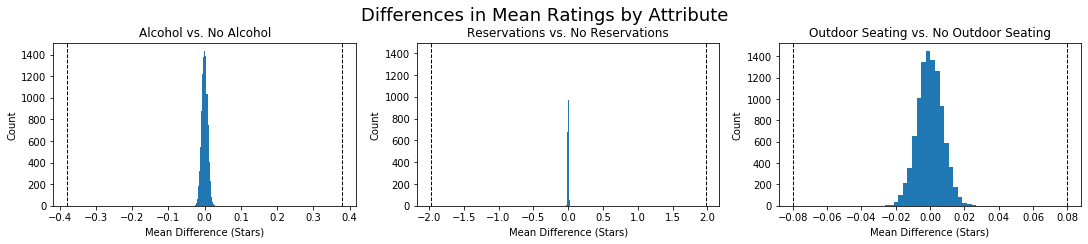

In [28]:
# Plot the histograms of the differences and the test statistics
att_diffs = [alcohol_noalcohol,res_nores,out_noout]
att_tt = [tt_alcohol,tt_reservations,tt_outdoor]
fig3,axes3 = plt.subplots(1,3,figsize=(15,3),constrained_layout=True)
fig3.suptitle('Differences in Mean Ratings by Attribute',size=18,y=1.08)
c = 0
for i in range(3):
    axes3[c].hist(att_diffs[i],bins=20)
    if i == 0:
        title = 'Alcohol vs. No Alcohol'
    elif i == 1:
        title = 'Reservations vs. No Reservations'
    else:
        title = 'Outdoor Seating vs. No Outdoor Seating'
    axes3[c].set_title(title)
    axes3[c].set(xlabel='Mean Difference (Stars)',ylabel='Count')
    axes3[c].axvline(att_tt[i].statistic,color='k',linestyle='dashed',linewidth=1)
    axes3[c].axvline(-att_tt[i].statistic,color='k',linestyle='dashed',linewidth=1)
    c += 1
pass;

## V. Restaurant Density and Restaurant Standing

Bootstrap inference will be used to perform t-tests on the following hypothesis.

#### Null hypothesis:

There is no difference in ratings between restaurants of one specific type regardless of restaurant density.

#### Alternative hypothesis:

There is significant difference in ratings between restaurants of one specific type depending on restaurant density.

In [29]:
# Create user defined function to calculate distance between two restaurants using latitudes and longitudes
def rest_distance(lat1,lon1,lat2,lon2):
    # approximate radius of earth in km
    R = 6378

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

# create user defined function for getting the restaurant density within one square km of a restaurant
def rest_density(restaurants):
    sqrkm_count = list()
    for lat, lon in zip(restaurants['latitude'],restaurants['longitude']):
        rd = 0
        for x, y in zip(restaurants['latitude'],restaurants['longitude']):
            dist = rest_distance(lat, lon, x, y)
            if 0 < dist <= 1:
                rd += 1
        sqrkm_count.append(rd)
    restaurants['square_km_count'] = sqrkm_count
    return restaurants

In [30]:
# Get all the Chinese restaurants in Toronto
rests = rests.sort_values(['latitude','longitude','stars','review_count']).reset_index(drop=True)
chinese = rests[rests['categories'].str.contains('Chinese') & rests['city'].str.contains('Toronto')]

In [31]:
# Get the densities around each Chinese restaurant
chinese = rest_density(chinese)

In [32]:
# Sort the Chinese restaurants by density square km count
chinese = chinese.sort_values('square_km_count',ascending=False).reset_index(drop=True)

In [33]:
# Get the shifted ratings of chinese restaurants
shifted_high = category_shift(chinese[chinese['square_km_count']>70]['stars'])
shifted_low = category_shift(chinese[chinese['square_km_count']<20]['stars'])

In [34]:
# Get bootstrap replicates of shifted by density ratings
bs_reps_high = draw_bs_replicates(shifted_high,np.mean,10000)
bs_reps_low = draw_bs_replicates(shifted_low,np.mean,10000)

In [35]:
# Calculate the test statistics and p values
dens_tt = stats.ttest_ind(bs_reps_high,bs_reps_low)
dens_tt

Ttest_indResult(statistic=-1.115641259570456, pvalue=0.26458912922895605)

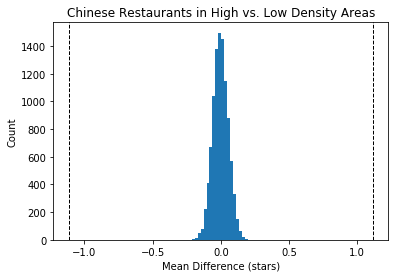

In [37]:
_ = plt.hist(bs_reps_high-bs_reps_low,bins=20)
_ = plt.xlabel('Mean Difference (stars)')
_ = plt.ylabel('Count')
_ = plt.title('Chinese Restaurants in High vs. Low Density Areas')
_ = plt.axvline(dens_tt[0], color='k',linestyle='dashed',linewidth=1)
_ = plt.axvline(-dens_tt[0], color='k',linestyle='dashed',linewidth=1)

I accept the null hypothesis with p value being greater than 0.05. There is no difference in the ratings of Chinese restaurants in a city regardless of the Chinese restaurant density in the location.

## Summary
Using bootstrap inference to perform t-tests on the hypotheses around restaurants, we found some significant relationships between variables in the data. Restaurant category affects restaurant rating. Restaurant standing affects the volatility in the restaurant's ratings over time. 